In [1]:
import h5py
import numpy as  np
from pathlib import Path
import matplotlib.pyplot as plt
from source import helper
import matplotlib.image
import random
from tqdm import tqdm
import pickle
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["image.interpolation"] = 'none'

In [2]:
def subtract_background(noise, data):
    avg = np.average(noise, axis=0)
    return data - avg

def gen_n_diff_spect(frames: np.array = None, distances: list=[0, 1, 10], use_db: bool = True) -> (list, np.ndarray):
    if frames is None:
        raise AttributeError("no frames specified")

    to_return = []
    for d in distances:
        if d == 0:
            spect,y = helper.gen_spectogram(frames)
            if use_db:
                spect = helper.to_dB(spect)
        else:
            spect = helper.diff_frames(frames,  d)
            spect,y =  helper.gen_spectogram(spect)
            if use_db:
                spect  = helper.to_dB(spect)

        to_return.append(spect[:,max(distances)-d:])
    return to_return,y



In [3]:
BASE_DIR = Path("D:/Studia/sium/semestr3/radar-project")  # change to your project dir
RADAR_DIR = BASE_DIR / "data/2023_03_21/chodzonko"  # day dir
GROUP_NAME = '2023_03_21' # nazwa grupy (np. dzień pomiaru), de facto to tylko kolejny wymiar
H5_FILENAME = 'alive_or_dead'
loaded_file = h5py.File('../data/'+ H5_FILENAME + '.h5','r')
loaded_file['2023_03_21'].keys()

<KeysViewHDF5 ['background', 'biegunko_1os_2m_rafal', 'chodzonko_1os_2m_bartek', 'chodzonko_1os_4-1-8m_bartek', 'odleglosc_1m_bartek_bokiem', 'odleglosc_1m_bartek_przodem', 'odleglosc_2m_bartek_bokiem', 'odleglosc_2m_bartek_przodem', 'odleglosc_3m_bartek_bokiem', 'odleglosc_3m_bartek_przodem', 'odleglosc_4m_bartek_bokiem', 'odleglosc_4m_bartek_przodem', 'randomowe_chodzonko_1os_bartek', 'wiatrak_1m', 'wiatrak_2m', 'wiatrak_3m', 'wiatrak_4m']>

In [41]:
filename = 'background'

In [23]:
frames = loaded_file[GROUP_NAME][filename]
frames = frames[:,0,0,:]

noise = loaded_file[GROUP_NAME]['background']
noise = noise[:,0,0,:]
frames = subtract_background(noise, frames)

In [42]:
# frames = loaded_file[GROUP_NAME][filename]
# frames = frames[:,0,0,:]

In [43]:
spects,y = gen_n_diff_spect(frames, distances=[0,1,10,50,100])

In [44]:
for i,s in  enumerate(spects):
    reduced = s[:50,:]
    reduced[reduced==np.NINF] = 0
    spects[i] = helper.normalize(reduced)

y = y[:50]

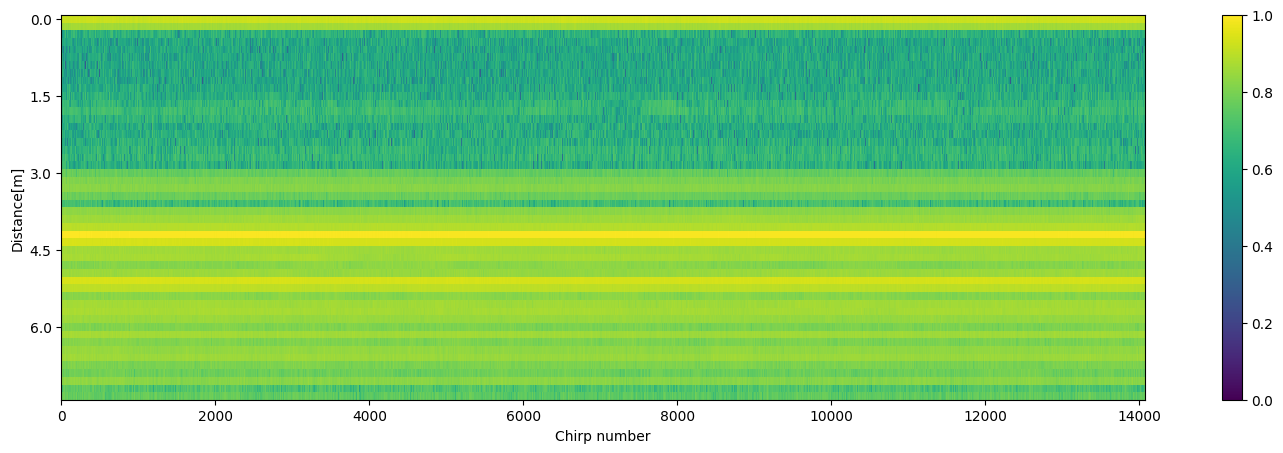

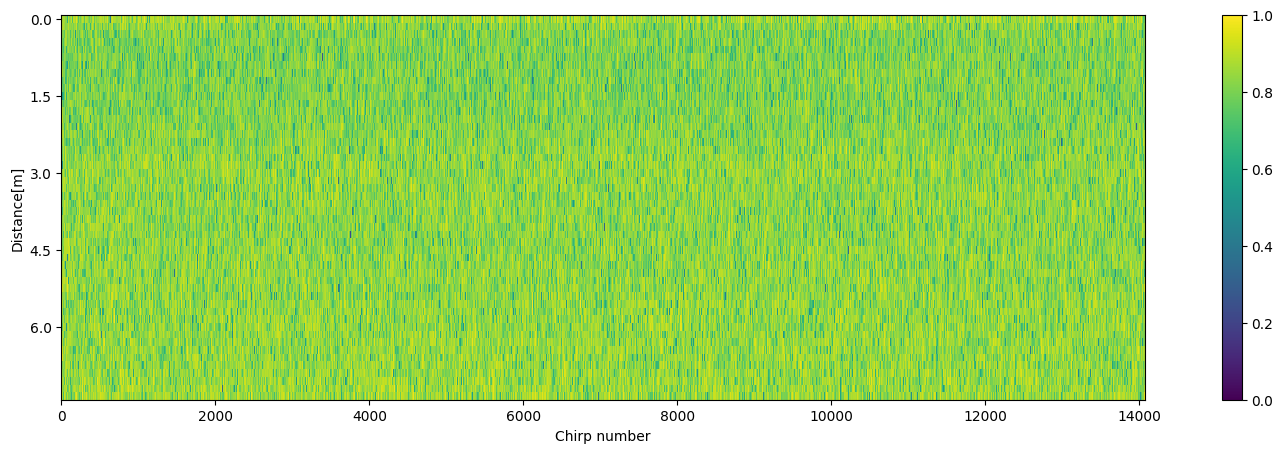

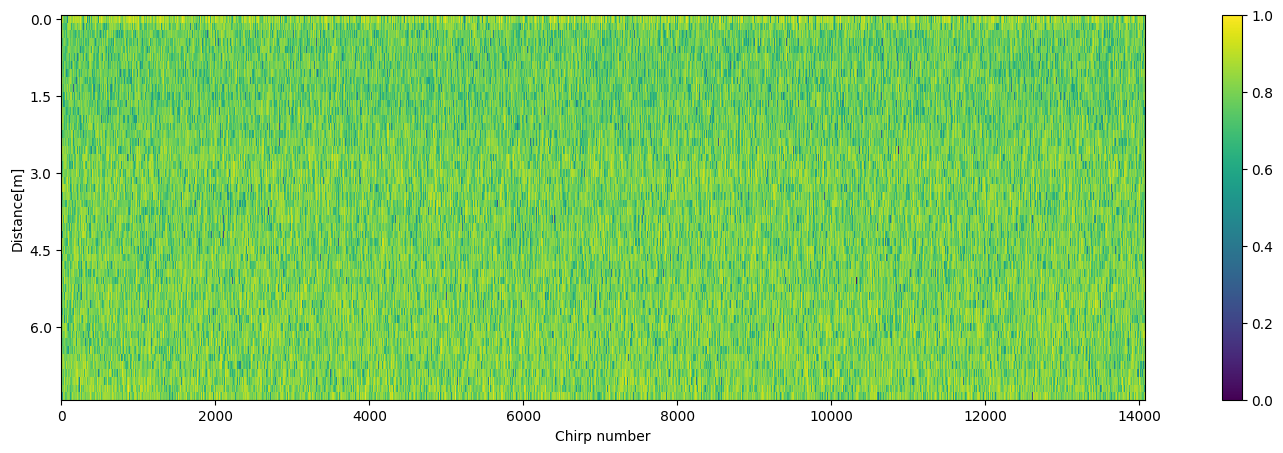

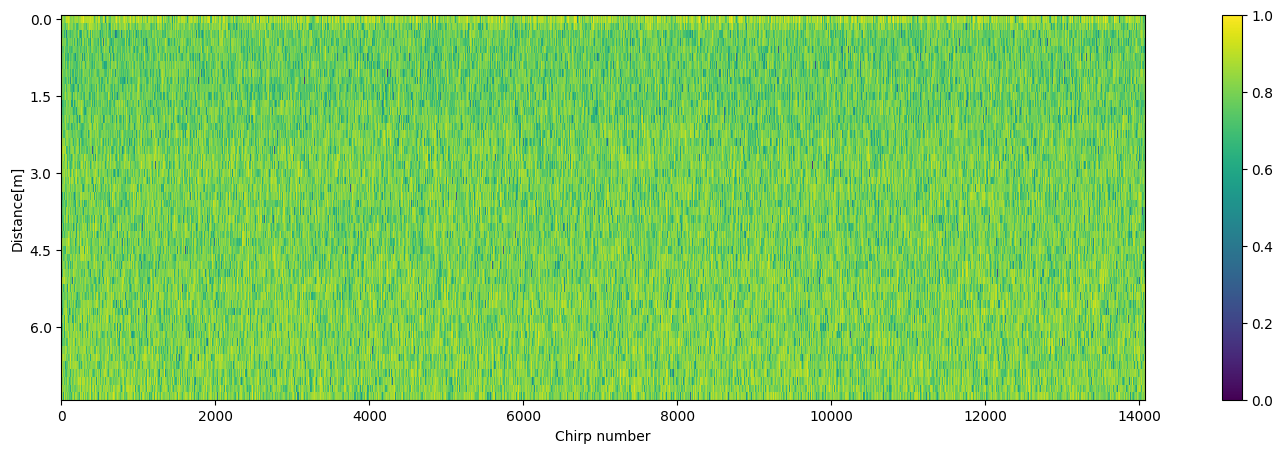

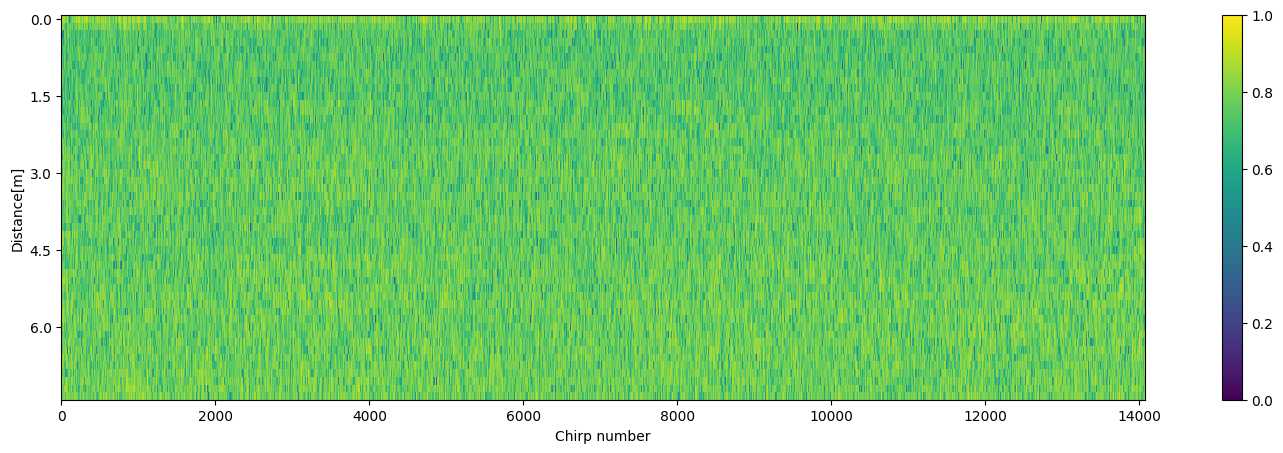

In [45]:
for s in spects:
    helper.print_spectogram(s,y, step=10, aspect=1/100)

In [46]:
matplotlib.image.imsave(filename+'.png', spects[4][:,::10])

In [47]:
img  = matplotlib.image.imread(filename+'.png')
trajectory = img[:,:,0] == 0
trajectory = np.repeat(trajectory,10, axis=1)

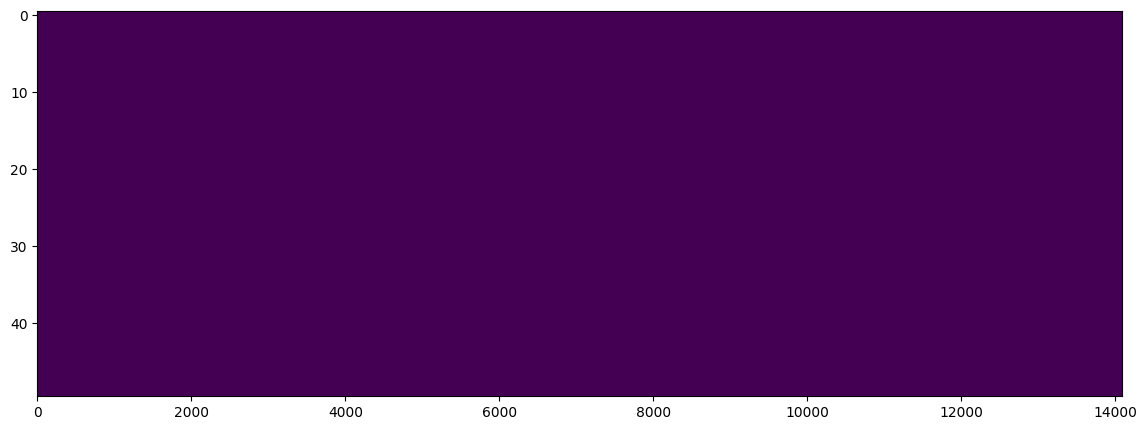

In [48]:
plt.imshow(trajectory, aspect=100)

In [49]:
trajectory.shape

(50, 14080)

In [50]:
# to make sure trajectory and spektrograms are the same length
_, x = spects[0].shape
_, y = trajectory.shape
if x-y != 0:
    trajectory = trajectory[:,:x-y]
smth = spects[0] + trajectory

In [51]:
trajectory.shape

(50, 14072)

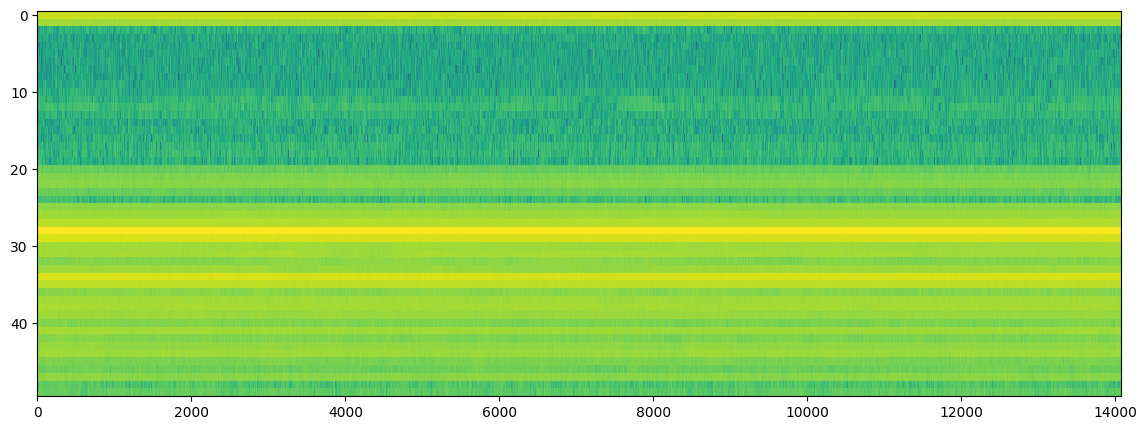

In [52]:
plt.imshow(smth, aspect=100)

In [53]:
spects = np.array(spects)

In [54]:
spects.shape

(5, 50, 14072)

In [55]:
X = []
y =[]
back = 10
for i in tqdm(range(trajectory.shape[1]-back)):
    window = spects[:,:,i:i+back]
    last = trajectory[:,i+back]
    try:
        id = last.tolist().index(1)
    except ValueError:
        id = 50
    X.append(window)
    y.append(id)
X = np.array(X)
y = np.array(y)

100%|██████████| 14062/14062 [00:00<00:00, 390528.20it/s]


In [56]:
X.shape

(14062, 5, 50, 10)

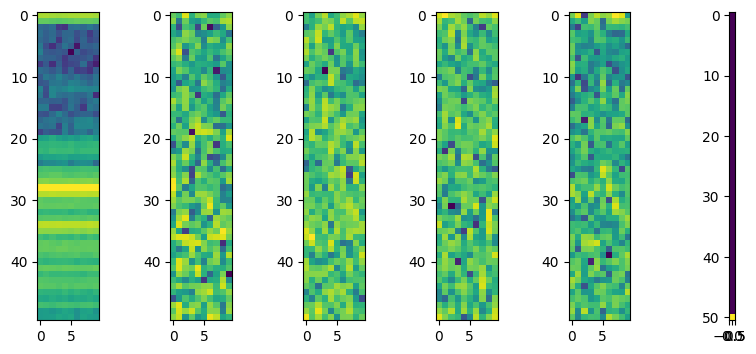

In [60]:
id = random.randint(0,len(X))
f, axarr = plt.subplots(1,6)
f.set_figwidth(10)
f.set_figheight(4)
axarr[0].imshow(X[id,0,:,:])
axarr[1].imshow(X[id,1,:,:])
axarr[2].imshow(X[id,2,:,:])
axarr[3].imshow(X[id,3,:,:])
axarr[4].imshow(X[id,4,:,:])
out = np.zeros((51,1))
out[y[id]] = 1
axarr[5].imshow(out)

In [58]:
with open('pickles/'+filename+'_X.pkl', 'wb') as f:
    pickle.dump(X, f)
f.close()
with open('pickles/'+filename+'_y.pkl', 'wb') as f:
    pickle.dump(y, f)
f.close()